In [1]:
import os
import csv
import numpy as np
import utils
import hrr_utils
import RM_utils
import time
import random

from scipy import spatial
from scipy.spatial import distance
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

cwd = os.getcwd()


alph = 'abcdefghijklmnopqrstuvwxyz#.'
N=1000
D = len(alph)
dic1 = letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


In [2]:
irreg_verbs1 = RM_utils.read_verbs('data/cleaned/R&M_irregular.csv')
irreg_verbs2 = RM_utils.read_verbs('data/cleaned/Brown_irregular_std=1.csv')
reg_verbs = RM_utils.read_verbs('data/cleaned/Brown_regular_std=0.25.csv')


In [3]:
irreg_verbs = irreg_verbs1

for freq, tenses in irreg_verbs2.items():
    irreg_verbs[freq] += tenses
    
for k, v in irreg_verbs.items():
    print (k, len(v))
    
comb_verbs = reg_verbs
for freq, tenses in irreg_verbs.items():
    comb_verbs[freq] += tenses

('high', 8)
('medium', 217)
('low', 49)


In [4]:
for k, v in irreg_verbs.items():
    print (k, len(v))
    
for k, v in reg_verbs.items():
    print (k, len(v))

('high', 8)
('medium', 217)
('low', 49)
('high', 260)
('medium', 1590)
('low', 871)


In [5]:
"""
10 high freq
410 med freq
86 low freq

irregular
8 high freq
76 med freq
14 low freq

regular
2 high freq
334 med freq
72 low freq 
"""

irreg_freqs = {'high': 8, 'medium': 76, 'low': 14}
reg_freqs = {'high': 2, 'medium': 334, 'low': 72}
comb_freqs = {'high': 10, 'medium': 410, 'low': 86}
irreg_vecs = RM_utils.gen_verb_set(irreg_verbs, irreg_freqs, N, dic1, dic2, alph)
reg_vecs = RM_utils.gen_verb_set(reg_verbs, reg_freqs, N, dic1, dic2, alph)
comb_vecs = RM_utils.gen_verb_set(comb_verbs, comb_freqs, N, dic1, dic2, alph)

In [6]:
"""
accuracy % = similarity normalized = similarity / N
-or by thresholding?

1. Try with only irregular: high, medium, low freq
2. Try with only regular: high, medium, low freq
3. Try with both: high, medium, low freq with 2 lines: total and irregular accuracy.
"""

'\naccuracy % = similarity normalized = similarity / N\n-or by thresholding?\n\n1. Try with only irregular: high, medium, low freq\n2. Try with only regular: high, medium, low freq\n3. Try with both: high, medium, low freq with 2 lines: total and irregular accuracy.\n'

In [7]:
x,y,ystd,accuracy = RM_utils.trigram_dict_onetype(irreg_vecs['past2'], irreg_vecs['past1'], RM_utils.train, N)

figures/unregularized_trigam_dict-N=1000-W=98-171130


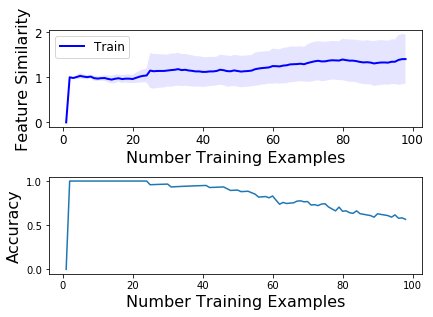

In [8]:
title = 'unregularized'
legend = 'upper left'
RM_utils.graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname


figures/unregularized_trigam_dict-N=1000-W=408-171130


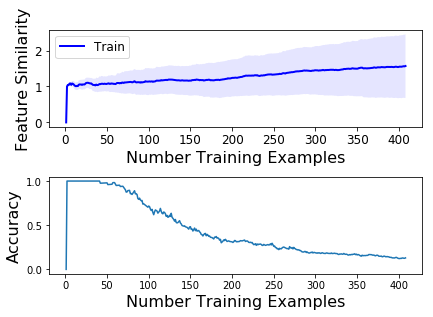

In [9]:
x,y,ystd,accuracy = RM_utils.trigram_dict_onetype(reg_vecs['past2'], reg_vecs['past1'], RM_utils.train, N)
title = 'unregularized'
legend = 'upper left'
RM_utils.graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=1000-W=408-171130


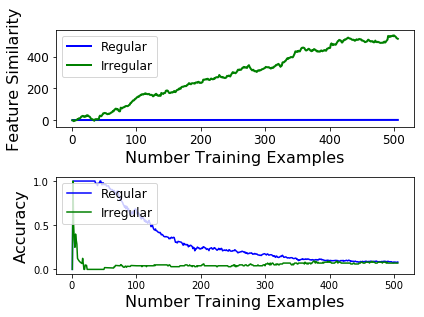

In [10]:
x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = RM_utils.trigram_dict(comb_vecs['past2'], comb_vecs['pres1'], irreg_vecs['past2'], irreg_vecs['pres1'], RM_utils.train, N)
title = 'unregularized'
legend = 'upper left'
RM_utils.graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=1000-W=98-171130


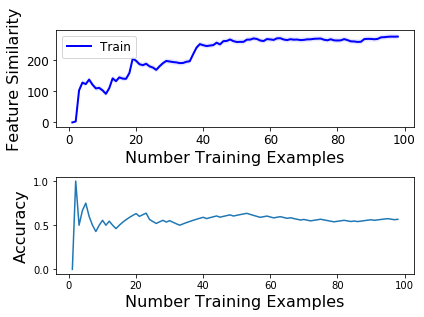

In [11]:
x,y,ystd,accuracy = RM_utils.diff_trigram_dict_onetype(irreg_vecs['past2'], irreg_vecs['past1'], irreg_vecs['pres2'], N)
title = 'unregularized'
legend = 'upper left'
RM_utils.graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=1000-W=408-171130


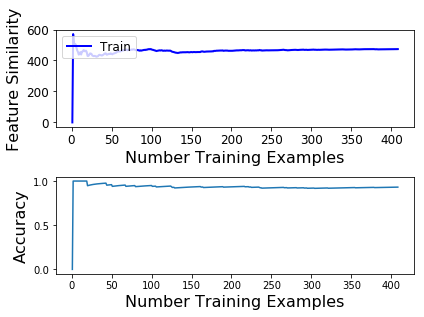

In [12]:
x,y,ystd,accuracy = RM_utils.diff_trigram_dict_onetype(reg_vecs['past2'], reg_vecs['past1'], reg_vecs['pres2'], N)
title = 'unregularized'
legend = 'upper left'
RM_utils.graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=1000-W=408-171130


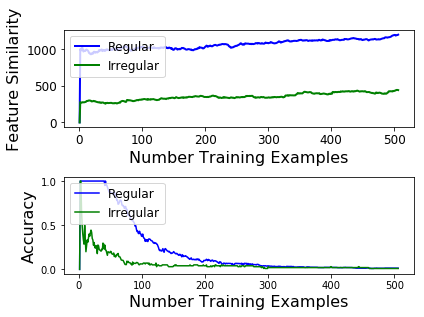

In [13]:
x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = RM_utils.diff_trigram_dict(comb_vecs['past2'], 
                                                                 comb_vecs['pres1'],
                                                                 comb_vecs['pres2'],
                                                                 irreg_vecs['past2'],
                                                                 irreg_vecs['pres1'],
                                                                 irreg_vecs['pres2'],
                                                                 N,
                                                                 RM_utils.train_diff
                                                                )
title = 'unregularized'
legend = 'upper left'
RM_utils.graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regularized_trigam_dict-N=1000-W=408-171130


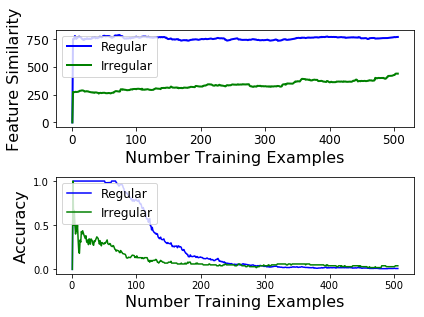

In [14]:
# regularization
x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = RM_utils.diff_trigram_dict(comb_vecs['past2'], 
                                                                 comb_vecs['pres1'],
                                                                 comb_vecs['pres2'],
                                                                 irreg_vecs['past2'],
                                                                 irreg_vecs['pres1'],
                                                                 irreg_vecs['pres2'],
                                                                 N,
                                                                 RM_utils.reg_train_diff
                                                                )
title = 'regularized'
legend = 'upper left'
RM_utils.graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)